In [43]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
feature_cols = [
    'log_churn',
    'dmm_unit_size',
    'dmm_unit_complexity',
    'time_diff',
    'msg_len',
    'has_fix_word',
    'weekday_sin', 'weekday_cos',
    'hour_sin', 'hour_cos'
]
id_cols = ['hash', 'repo_url', 'author_date']
df = pd.read_csv('../data/data/processed/icvul_features_final.csv')
print("Shape:", df.shape)
X = df[feature_cols]
y = df['label']

Shape: (8690, 14)


In [46]:
df_sorted = df.sort_values("author_date")
split_idx = int(0.8 * len(df_sorted))
train_idx_temp = df_sorted.index[:split_idx]
test_idx_temp  = df_sorted.index[split_idx:]

X_train_temp, y_train_temp = X.loc[train_idx_temp], y.loc[train_idx_temp]
X_test_temp,  y_test_temp  = X.loc[test_idx_temp],  y.loc[test_idx_temp]

from sklearn.model_selection import train_test_split
idx_train_rand, idx_test_rand = train_test_split(df.index, test_size=0.2, stratify=y, random_state=42)
X_train_rand, y_train_rand = X.loc[idx_train_rand], y.loc[idx_train_rand]
X_test_rand,  y_test_rand  = X.loc[idx_test_rand],  y.loc[idx_test_rand]

print("Temporal split sizes:", X_train_temp.shape[0], X_test_temp.shape[0])
print("Random split sizes:", X_train_rand.shape[0], X_test_rand.shape[0])


Temporal split sizes: 6952 1738
Random split sizes: 6952 1738


In [47]:
base_mlp = MLPClassifier(
    activation="relu",
    solver="adam",
    batch_size=64,
    random_state=42,
    max_iter=300
)


In [48]:
tscv = TimeSeriesSplit(n_splits=5)
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)

param_grid = {
    "hidden_layer_sizes": [(32,), (64,), (128,), (64,32), (128,64), (128,64,32)],
    "alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    "learning_rate_init": [5e-4, 1e-3, 2e-3],
    "batch_size": [32, 64]
}

from scipy.stats import loguniform
param_dist = {
    "hidden_layer_sizes": [(64,), (128,), (256,), (64,32), (128,64)],
    "alpha": loguniform(1e-6, 1e-1),
    "learning_rate_init": loguniform(3e-4, 3e-2),
    "batch_size": [32, 64, 128]
}

In [49]:
grid = GridSearchCV(
    estimator=base_mlp,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=tscv,
    n_jobs=-1,
    refit=True,
    verbose=1
)
grid.fit(X_train_temp, y_train_temp)
best_mlp_grid = grid.best_estimator_
print("Grid best AUC (CV):", grid.best_score_, "\nBest params:", grid.best_params_)

rand = RandomizedSearchCV(
    estimator=base_mlp,
    param_distributions=param_dist,
    n_iter=60,
    scoring="roc_auc",
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1
)
rand.fit(X_train_temp, y_train_temp)
best_mlp_rand = rand.best_estimator_
print("Randomized best AUC (CV):", rand.best_score_, "\nBest params:", rand.best_params_)

halv = HalvingRandomSearchCV(
    estimator=base_mlp,
    param_distributions=param_dist,
    n_candidates='exhaust',
    scoring="roc_auc",
    cv=tscv,
    factor=3,
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1
)
halv.fit(X_train_temp, y_train_temp)
best_mlp_halv = halv.best_estimator_
print("Halving best AUC (CV):", halv.best_score_, "\nBest params:", halv.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimiza

Grid best AUC (CV): 0.8586366170271882 
Best params: {'alpha': 0.01, 'batch_size': 64, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0005}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimiza

Randomized best AUC (CV): 0.8687820665536545 
Best params: {'alpha': np.float64(0.08244312190905081), 'batch_size': 32, 'hidden_layer_sizes': (256,), 'learning_rate_init': np.float64(0.015739903600875838)}
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 20
max_resources_: 6952
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 347
n_resources: 20
Fitting 5 folds for each of 347 candidates, totalling 1735 fits


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-package

----------
iter: 1
n_candidates: 116
n_resources: 60
Fitting 5 folds for each of 116 candidates, totalling 580 fits


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


----------
iter: 2
n_candidates: 39
n_resources: 180
Fitting 5 folds for each of 39 candidates, totalling 195 fits


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


----------
iter: 3
n_candidates: 13
n_resources: 540
Fitting 5 folds for each of 13 candidates, totalling 65 fits


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


----------
iter: 4
n_candidates: 5
n_resources: 1620
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimiza

----------
iter: 5
n_candidates: 2
n_resources: 4860
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 

Halving best AUC (CV): 0.8571418841093674 
Best params: {'alpha': np.float64(0.09967548704385266), 'batch_size': 64, 'hidden_layer_sizes': (256,), 'learning_rate_init': np.float64(0.003872439718651578)}



MLP (Grid) — Temporal holdout | ROC-AUC: 0.8281  AP: 0.7991
              precision    recall  f1-score   support

           0     0.8576    0.5635    0.6801      1047
           1     0.5648    0.8582    0.6812       691

    accuracy                         0.6807      1738
   macro avg     0.7112    0.7108    0.6807      1738
weighted avg     0.7411    0.6807    0.6806      1738


MLP (Randomized) — Temporal holdout | ROC-AUC: 0.8257  AP: 0.8056
              precision    recall  f1-score   support

           0     0.8487    0.5463    0.6647      1047
           1     0.5536    0.8524    0.6712       691

    accuracy                         0.6680      1738
   macro avg     0.7011    0.6994    0.6680      1738
weighted avg     0.7313    0.6680    0.6673      1738


MLP (Halving) — Temporal holdout | ROC-AUC: 0.8294  AP: 0.8065
              precision    recall  f1-score   support

           0     0.8540    0.5530    0.6713      1047
           1     0.5585    0.8567    0.6762  

,method,cv_auc,test_auc,best_params
0,Grid,0.858637,0.828119,"{'alpha': 0.01, 'batch_size': 64, 'hidden_laye..."
1,Randomized,0.868782,0.825747,"{'alpha': 0.08244312190905081, 'batch_size': 3..."
2,Halving,0.857142,0.829420,"{'alpha': 0.09967548704385266, 'batch_size': 6..."


<Figure size 800x600 with 0 Axes>

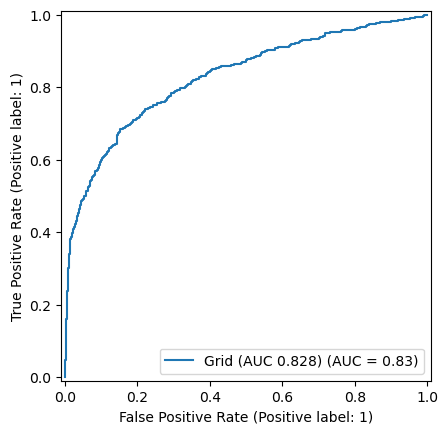

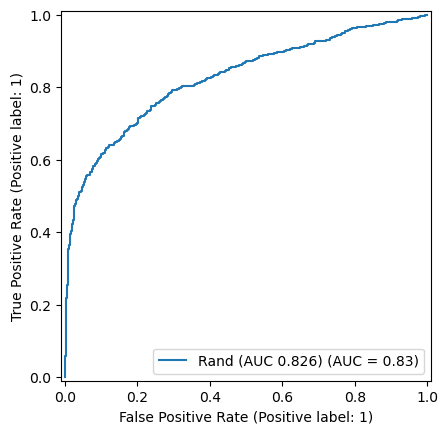

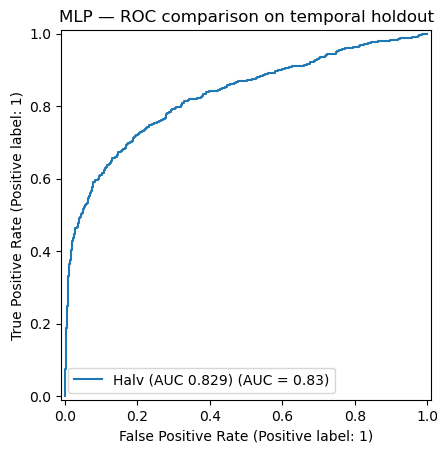

In [50]:
def eval_on_holdout(est, X_test, y_test, name):
    y_prob = est.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    auc = roc_auc_score(y_test, y_prob)
    ap  = average_precision_score(y_test, y_prob)
    print(f"\n{name} — Temporal holdout | ROC-AUC: {auc:.4f}  AP: {ap:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    return {"auc": auc, "ap": ap, "y_prob": y_prob}

res_grid = eval_on_holdout(best_mlp_grid, X_test_temp, y_test_temp, "MLP (Grid)")
res_rand = eval_on_holdout(best_mlp_rand, X_test_temp, y_test_temp, "MLP (Randomized)")
res_halv = eval_on_holdout(best_mlp_halv, X_test_temp, y_test_temp, "MLP (Halving)")

summary_mlp = pd.DataFrame([
    {"method": "Grid", "cv_auc": grid.best_score_, "test_auc": res_grid["auc"], "best_params": grid.best_params_},
    {"method": "Randomized", "cv_auc": rand.best_score_, "test_auc": res_rand["auc"], "best_params": rand.best_params_},
    {"method": "Halving", "cv_auc": halv.best_score_, "test_auc": res_halv["auc"], "best_params": halv.best_params_},
])
print("\nMLP summary:")
display(summary_mlp)

plt.figure(figsize=(8,6))
RocCurveDisplay.from_predictions(y_test_temp, res_grid["y_prob"], name=f"Grid (AUC {res_grid['auc']:.3f})")
RocCurveDisplay.from_predictions(y_test_temp, res_rand["y_prob"], name=f"Rand (AUC {res_rand['auc']:.3f})")
RocCurveDisplay.from_predictions(y_test_temp, res_halv["y_prob"], name=f"Halv (AUC {res_halv['auc']:.3f})")
plt.title("MLP — ROC comparison on temporal holdout")
plt.legend()
plt.show()